In [1]:
import torch
from torch import nn
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [76]:
# process the data
# take percent for example

folder = "../gyy/"
data = np.zeros(10, dtype=float)
label = np.zeros(1, dtype=float)

for id in range(5):
    filename = "random_4_0.1_1.0_" + str(id) + ".txt"
    new_data = np.genfromtxt(folder + filename)
    data = np.vstack([data, new_data[:, 0:20:2]])
    label = np.hstack([label, new_data[:, -1]])

data = data[1:, :]
label = label[1:]

In [61]:
# scale up
label = label * 100

In [77]:
# transform the data type

data = torch.from_numpy(data)
label = torch.from_numpy(label)

In [79]:
'''设置超参数'''
feature_number = 10  # 设置特征数目
out_prediction = 1  # 设置输出数目
learning_rate = 0.01  # 设置学习率
epochs = 20  # 设置训练代数
batch_size = 64

In [80]:
torch_dataset = torch.utils.data.TensorDataset(data, label)

# 划分训练集测试集与验证集
torch.manual_seed(seed=2021) # 设置随机种子分关键，不然每次划分的数据集都不一样，不利于结果复现
# 大概是98：1：1的比例划分
train_validaion, test = torch.utils.data.random_split(
    torch_dataset,
    [2891000, 59265],
)  # 先将数据集拆分为训练集+验证集
train, validation = torch.utils.data.random_split(
    train_validaion, [2830000, 61000])  # 再将训练集+验证集拆分为训练集，测试集
 
# 再将训练集划分批次，每batch_size个数据一批（测试集与验证集不划分批次）
train_data = torch.utils.data.DataLoader(train,
                                         batch_size=batch_size,
                                         shuffle=True)

In [81]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_output):  # n_feature为特征数目，这个数字不能随便取,n_output为特征对应的输出数目，也不能随便取
        self.n_feature=n_feature
        self.n_output=n_output
        super(Net, self).__init__()
        self.predict = torch.nn.Linear(self.n_feature, self.n_output) # 输出层
 
    def forward(self, x):
        '''定义前向传递过程'''
        x = x.to(torch.float32)
        out = self.predict( # 回归问题最后一层不需要激活函数
            x
        )  # 除去feature_number与out_prediction不能随便取，隐藏层数与其他神经元数目均可以适当调整以得到最佳预测效果
        return out.squeeze(-1)

In [82]:
net = Net(n_feature=feature_number,
                      n_output=out_prediction,
) # 这里直接确定了隐藏层数目以及神经元数目，实际操作中需要遍历

# optimizer = optim.Adam(net.parameters(), learning_rate)  # 使用Adam算法更新参数
optimizer = optim.SGD(net.parameters(), learning_rate)   # SGD

# criteon = torch.nn.MSELoss()  # 均方误差
# criteon = torch.nn.L1Loss()   # L1 loss
# criteon = torch.nn.SmoothL1Loss()   # smoothl1
criteon = torch.nn.HuberLoss()

val_loss = []
train_loss = []
 
for epoch in range(epochs):  # 整个数据集迭代次数
    net.train() # 启动训练模式
    batch_loss = []
    for batch_idx, (data, target) in enumerate(train_data):
        logits = net.forward(data)  # 前向计算结果（预测结果）
        logits = logits.to(torch.float32)
        target = target.to(torch.float32)
        loss = criteon(logits, target)  # 计算损失
        batch_loss.append(loss.item())
        optimizer.zero_grad()  # 梯度清零
        loss.backward()  # 后向传递过程
        optimizer.step()  # 优化权重与偏差矩阵
    train_loss.append(sum(batch_loss) / len(batch_loss))

    logit = []  # 这个是验证集，可以根据验证集的结果进行调参，这里根据验证集的结果选取最优的神经网络层数与神经元数目
    target = []
    net.eval() # 启动测试模式
    for data, targets in validation:  # 输出验证集的平均误差
        logits = net.forward(data).detach().numpy()
        targets = targets.detach().numpy()
        target.append(targets)
        logit.append(logits)

    target = [float(arr) for arr in target]
    logit = [float(arr) for arr in logit]
    average_loss = criteon(torch.tensor(logit), torch.tensor(target))
    val_loss.append(average_loss.item())
    print('\nTrain Epoch {}: The Average loss of VAL is {}'.format(epoch, average_loss.item()))


Train Epoch 0: The Average loss of VAL is 0.000686590385157615

Train Epoch 1: The Average loss of VAL is 0.0006836062530055642

Train Epoch 2: The Average loss of VAL is 0.0006821250426582992

Train Epoch 3: The Average loss of VAL is 0.0006819761474616826

Train Epoch 4: The Average loss of VAL is 0.0006809821352362633

Train Epoch 5: The Average loss of VAL is 0.0006808399339206517

Train Epoch 6: The Average loss of VAL is 0.0006810934864915907

Train Epoch 7: The Average loss of VAL is 0.0006806765450164676

Train Epoch 8: The Average loss of VAL is 0.0006808125181123614

Train Epoch 9: The Average loss of VAL is 0.0006806888850405812

Train Epoch 10: The Average loss of VAL is 0.0006806866731494665

Train Epoch 11: The Average loss of VAL is 0.0006808385369367898

Train Epoch 12: The Average loss of VAL is 0.0006805048324167728

Train Epoch 13: The Average loss of VAL is 0.0006807990139350295

Train Epoch 14: The Average loss of VAL is 0.0006806783494539559

Train Epoch 15: The 

In [83]:
prediction = []
test_y = []
net.eval() # 启动测试模式
for test_x, test_ys in test:
    predictions = net(test_x)
    predictions = predictions.detach().numpy()
    prediction.append(predictions)
    test_ys.detach().numpy()
    test_y.append(test_ys)
'''prediction = scaler.inverse_transform(np.array(prediction).reshape(
    -1, 1))  # 将数据恢复至归一化之前
test_y = scaler.inverse_transform(np.array(test_y).reshape(-1, 1))'''
prediction = [float(arr) for arr in prediction]
test_y = [float(arr) for arr in test_y]
# 均方误差计算
test_loss = criteon(torch.tensor(prediction ,dtype=torch.float32), torch.tensor(test_y, dtype=torch.float32))
print('测试集均方误差：',test_loss.detach().numpy())

测试集均方误差： 0.00067522435


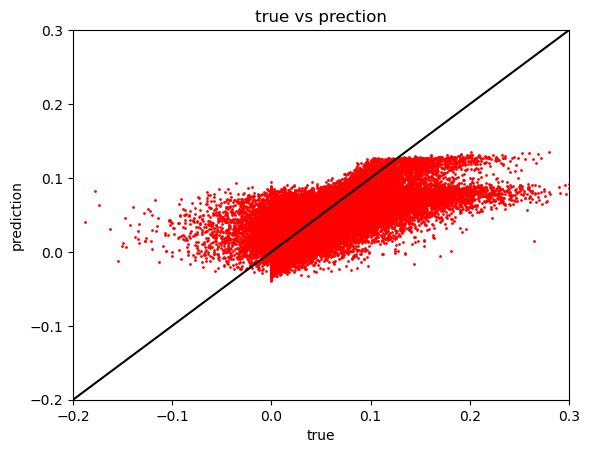

In [84]:
# 可视化
l_lim, r_lim = -0.2, 0.3
plt.figure()
plt.scatter(test_y, prediction, color='red', s=1)
plt.plot([l_lim, r_lim], [l_lim, r_lim], color='black', linestyle='-')
plt.xlim([l_lim, r_lim])
plt.ylim([l_lim, r_lim])
plt.xlabel('true')
plt.ylabel('prediction')
plt.title('true vs prection')
plt.show()

In [72]:
# 打印参数
for _,param in enumerate(net.parameters()):
    print(param)
    print('----------------')

Parameter containing:
tensor([[ 5.8133, -1.1505,  1.0436,  1.2151,  1.9532,  3.2489,  0.0336,  2.4541,
          2.0865,  0.2564]], requires_grad=True)
----------------
Parameter containing:
tensor([-2.2665], requires_grad=True)
----------------


range(1, 21)
[2.3816984893845996, 2.203039597502131, 2.1962404290748343, 2.1953820069929284, 2.1951087029558685, 2.1949688574071033, 2.194868954264726, 2.1948050464743547, 2.1947516633621045, 2.1947108307654224, 2.1946806402296897, 2.1946491922029616, 2.194633624901665, 2.194620664253194, 2.194600395914733, 2.1945892504823883, 2.1945826838827918, 2.1945829339347838, 2.194566032911658, 2.194549277011331]


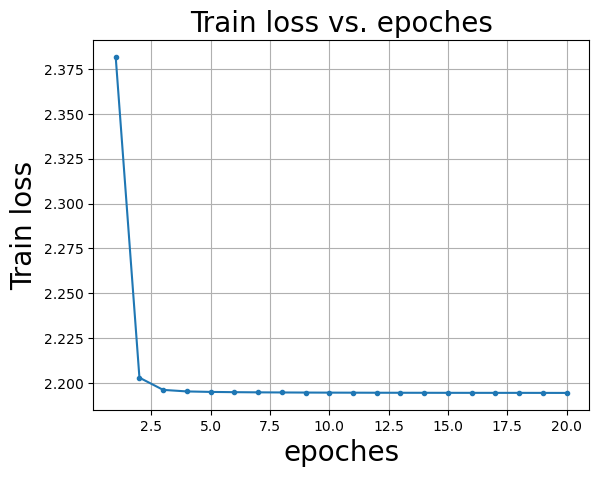

In [73]:
# 绘制train loss
plt.cla()
x1 = range(1, epochs + 1)
print(x1)
y1 = train_loss
print(y1)
plt.title('Train loss vs. epoches', fontsize=20)
plt.plot(x1, y1, '.-')
plt.xlabel('epoches', fontsize=20)
plt.ylabel('Train loss', fontsize=20)
plt.grid()
'''plt.savefig("./lossAndacc/Train_loss.png")
plt.savefig("./lossAndacc/Train_loss.png")'''
plt.show()

range(1, 21)
[2.215750217437744, 2.196969747543335, 2.195483684539795, 2.1951775550842285, 2.195056438446045, 2.1949596405029297, 2.194891929626465, 2.194864273071289, 2.1948165893554688, 2.1947813034057617, 2.1947479248046875, 2.194739818572998, 2.194693088531494, 2.1947131156921387, 2.1947169303894043, 2.194674491882324, 2.194715976715088, 2.1946916580200195, 2.194735050201416, 2.1948325634002686]


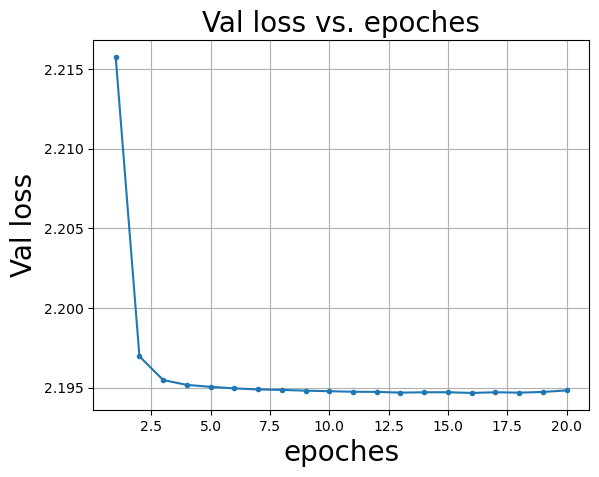

In [74]:
# 绘制val loss
plt.cla()
x1 = range(1, epochs+1)
print(x1)
y1 = val_loss
print(y1)
plt.title('Val loss vs. epoches', fontsize=20)
plt.plot(x1, y1, '.-')
plt.xlabel('epoches', fontsize=20)
plt.ylabel('Val loss', fontsize=20)
plt.grid()
'''plt.savefig("./lossAndacc/Train_loss.png")
plt.savefig("./lossAndacc/Train_loss.png")'''
plt.show()

In [75]:
# save & load the model

path = "./model"
file_name = "/sgd_huber_scale.pkl"
torch.save(net, path + file_name)

'''
model = torch.load(path + file_name)
model.eval()
'''

'\nmodel = torch.load(path + file_name)\nmodel.eval()\n'